# Week 0 - Retreiving and Preparing Text for Machines

This week, we begin by "begging, borrowing and stealing" text from several
contexts of human communication (e.g., PDFs, HTML, Word) and preparing it for
machines to "read" and analyze. This notebook outlines scraping text from the
web, PDF and Word documents. Then we detail "spidering" or walking
through hyperlinks to build samples of online content, and using APIs,
Application Programming Interfaces, provided by webservices to access their
content. Along the way, we will use regular expressions, outlined in the
reading, to remove unwanted formatting and ornamentation. Finally, we discuss
various text encodings, filtering and data structures in which text can be
placed for analysis.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import bs4 #called `beautifulsoup4`, an html parser
import pandas #gives us DataFrames
import docx #reading MS doc files, install as `python-docx`

#Stuff for pdfs
#Install as `pdfminer2`
import pdfminer.pdfinterp
import pdfminer.converter
import pdfminer.layout
import pdfminer.pdfpage

#These come with Python
import re #for regexs
import urllib.parse #For joining urls
import io #for making http requests look like files
import json #For Tumblr API responses
import os.path #For checking if files exist
import os #For making directories

We will also be working on the following files/urls

In [2]:
wikipedia_base_url = 'https://en.wikipedia.org'
wikipedia_content_analysis = 'https://en.wikipedia.org/wiki/Content_analysis'
content_analysis_save = 'wikipedia_content_analysis.html'
example_text_file = 'sometextfile.txt'
information_extraction_pdf = 'https://github.com/Computational-Content-Analysis-2018/Data-Files/raw/master/1-intro/Content%20Analysis%2018.pdf'
example_docx = 'https://github.com/Computational-Content-Analysis-2018/Data-Files/raw/master/1-intro/macs6000_connecting_to_midway.docx'
example_docx_save = 'example.docx'

# Scraping

Before we can start analyzing content we need to obtain it. Sometimes it will be
provided to us from a pre-curated text archive, but sometimes we will need to
download it. As a starting example we will attempt to download the wikipedia
page on content analysis. The page is located at [https://en.wikipedia.org/wiki/
Content_analysis](https://en.wikipedia.org/wiki/Content_analysis) so lets start
with that.

We can do this by making an HTTP GET request to that url, a GET request is
simply a request to the server to provide the contents given by some url. The
other request we will be using in this class is called a POST request and
requests the server to take some content we provide. While the Python standard
library does have the ability do make GET requests we will be using the
[_requests_](http://docs.python-requests.org/en/master/) package as it is _'the
only Non-GMO HTTP library for Python'_...also it provides a nicer interface.

In [3]:
#wikipedia_content_analysis = 'https://en.wikipedia.org/wiki/Content_analysis'
requests.get(wikipedia_content_analysis)

<Response [200]>

`'Response [200]'` means the server responded with what we asked for. If you get
another number (e.g. 404) it likely means there was some kind of error, these
codes are called HTTP response codes and a list of them can be found
[here](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes). The response
object contains all the data the server sent including the website's contents
and the HTTP header. We are interested in the contents which we can access with
the `.text` attribute.

In [4]:
wikiContentRequest = requests.get(wikipedia_content_analysis)
print(wikiContentRequest.text[:1000])

<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>Content analysis - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"X-spLgpAICEAAKaLicQAAAAF","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Content_analysis","wgTitle":"Content analysis","wgCurRevisionId":991020438,"wgRevisionId":991020438,"wgArticleId":473317,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles needing expert attention with no reason or talk parameter","Articles needing expert attention from April 2008","All articles needing expert attention","Sociology ar

This is not what we were looking for, because it is the start of the HTML that
makes up the website. This is HTML and is meant to be read by computers. Luckily
we have a computer to parse it for us. To do the parsing we will use [_Beautiful
Soup_](https://www.crummy.com/software/BeautifulSoup/) which is a better parser
than the one in the standard library.

But before we proceed to Beautiful Soup, a digression about Python syntax, especially about objects and functions.
For those who are not familiar with the syntax of python (or, if you're familiar with R programming), you might wonder what requests.get or wikiContentRequest.text mean. To understand this, you need to first understand what objects are. You may have heard that Python is an object oriented programming language (unlike the procedure oriented programming language, an example of which is R). Object is a set of variables (or, data) and functions into which you pass your data. So, in object oriented programming languages, like python, variables and functions are bunleded into objects.

For example, let's look at wikiContentRequest. We use dir() function, which returns the list of attributes and functions of objects.

In [5]:
 dir(wikiContentRequest)

['__attrs__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_content',
 '_content_consumed',
 '_next',
 'apparent_encoding',
 'close',
 'connection',
 'content',
 'cookies',
 'elapsed',
 'encoding',
 'headers',
 'history',
 'is_permanent_redirect',
 'is_redirect',
 'iter_content',
 'iter_lines',
 'json',
 'links',
 'next',
 'ok',
 'raise_for_status',
 'raw',
 'reason',
 'request',
 'status_code',
 'text',
 'url']

There's 'text' here. We used 'wikiContentRequest.text' to access 'text.' In other words, we use .(dot notation) to access functions from objects. wikiContentRequest has a set of functions, as shown above, and we used 'wikiContentRequest.text' to access one of them. By the way, dot notations do not necessarily refer to functions--it refers to anything that the entity contains. 



Moving on to the next step: BeautifulSoup, a Python library which extracts data from HTML and XML, and transforms HTML files into Python objects.

In [6]:
wikiContentSoup = bs4.BeautifulSoup(wikiContentRequest.text, 'html.parser')
print(wikiContentSoup.text[:200])





Content analysis - Wikipedia































Content analysis

From Wikipedia, the free encyclopedia



Jump to navigation
Jump to search
This article needs attention from an expert


This is better but there's still random whitespace and we have more than just
the text of the article. This is because what we requested is the whole webpage,
not just the text for the article.

We want to extract only the text we care about, and in order to do this we will
need to inspect the html. One way to do this is simply to go to the website with
a browser and use its inspection or view source tool. If javascript or other
dynamic loading occurs on the page, however, it is likely that what Python
receives is not what you will see, so we will need to inspect what Python
receives. To do this we can save the html `requests` obtained.

In [7]:
#content_analysis_save = 'wikipedia_content_analysis.html'

with open(content_analysis_save, mode='w', encoding='utf-8') as f:
    f.write(wikiContentRequest.text)

open() is a function which literally opens and returns the file. This function has multiple modes, and, here, we used mode as 'w', which means: open a file for writing. And then, we use 'write' function to write on the empty file (content_analysis_save) that we created using open(content_analysis_save, mode='w', encoding='utf-8').} What did we write on this file? The text we got from wikiContentRequest.text

Now let's open the file (`wikipedia_content_analysis.html`) we just created with
a web browser. It should look sort of like the original but without the images
and formatting.

As there is very little standardization on structuring webpages, figuring out
how best to extract what you want is an art. Looking at this page it looks like
all the main textual content is inside `<p>`(paragraph) tags within the `<body>`
tag. 

In [8]:
contentPTags = wikiContentSoup.body.findAll('p')
for pTag in contentPTags[:3]:
    print(pTag.text)

Content analysis is the study of documents and communication artifacts, which might be texts of various formats, pictures, audio or video. Social scientists use content analysis to examine patterns in communication in a replicable and systematic manner.[1] One of the key advantages of using content analysis to analyse social phenomena is its non-invasive nature, in contrast to simulating social experiences or collecting survey answers.

Practices and philosophies of content analysis vary between academic disciplines. They all involve systematic reading or observation of texts or artifacts which are assigned labels (sometimes called codes) to indicate the presence of interesting, meaningful pieces of content.[2][3] By systematically labeling the content of a set of texts, researchers can analyse patterns of content quantitatively using statistical methods, or use qualitative methods to analyse meanings of content within texts.

Computers are increasingly used in content analysis to auto

Another excursion for those who are not familiar with programming: for loop. For loop is used to iterate over a sequence. "ContentPTags" contains multiple paragraphs, each of which starts and ends with `<p>`. What the "for pTag in contentPtags[:3]" does here is: find each paragraph in contentPTags, which, here, we limited to the first three using contentPtags[:3], and then print each paragraph. So, we have three paragraphs. By the way, you can insert `<p>` in juputer notebook!

We now have all the text from the page, split up by paragraph. If we wanted to
get the section headers or references as well it would require a bit more work,
but is doable.

There is one more thing we might want to do before sending this text to be
processed, remove the references indicators (`[2]`, `[3]` , etc). To do this we
can use a short regular expression (regex).

In [9]:
contentParagraphs = []
for pTag in contentPTags:
    #strings starting with r are raw so their \'s are not modifier characters
    #If we didn't start with r the string would be: '\\[\\d+\\]'
    contentParagraphs.append(re.sub(r'\[\d+\]', '', pTag.text))

#convert to a DataFrame
contentParagraphsDF = pandas.DataFrame({'paragraph-text' : contentParagraphs})
print(contentParagraphsDF)

                                       paragraph-text
0   Content analysis is the study of documents and...
1   Practices and philosophies of content analysis...
2   Computers are increasingly used in content ana...
3   Content analysis is best understood as a broad...
4   The simplest and most objective form of conten...
5   A further step in analysis is the distinction ...
6   Quantitative content analysis highlights frequ...
7   Siegfried Kracauer provides a critique of quan...
8   More generally, content analysis is research u...
9   By having contents of communication available ...
10  Computer-assisted analysis can help with large...
11  Robert Weber notes: "To make valid inferences ...
12  There are five types of texts in content analy...
13  Over the years, content analysis has been appl...
14  In recent times, particularly with the advent ...
15  Quantitative content analysis has enjoyed a re...
16  Content analysis can also be described as stud...
17  Manifest content is read

Since we learned how to do for loop, you might get what we did here: using contentParagraphs = [], we made an empty list; and then, for each paragraph in contentPTags, we substituted every [\d+\] with '', i.e., removed every [\d+\], and then appended each paragraph (now without [\d+\]) to the empty list. As we can see, we have a dataframe, each row of which is each paragraph of contentPTags, without reference indicators. 

By the way, what does [\d+\] mean? If you are not familiar with regex, it is a way of specifying searches in text.
A regex engine takes in the search pattern, in the above case `'\[\d+\]'` and
some string, the paragraph texts. Then it reads the input string one character
at a time checking if it matches the search. Here the regex `'\d'` matches
number characters (while `'\['` and `'\]'` capture the braces on either side).

Now we have a `DataFrame` containing all relevant text from the page ready to be processed

In [10]:
findNumber = r'\d'
regexResults = re.search(findNumber, 'not a number, not a number, numbers 2134567890, not a number')
regexResults

<re.Match object; span=(36, 37), match='2'>

In Python the regex package (`re`) usually returns `Match` objects (you can have
multiple pattern hits in a a single `Match`), to get the string that matched our
pattern we can use the `.group()` method, and as we want the first one we will
ask for the 0'th group.

In [11]:
print(regexResults.group(0))

2


That gives us the first number, if we wanted the whole block of numbers we can
add a wildcard `'+'` which requests 1 or more instances of the preceding
character.

In [12]:
findNumbers = r'\d+'
regexResults = re.search(findNumbers, 'not a number, not a number, numbers 2134567890, not a number')
print(regexResults.group(0))

2134567890


Now we have the whole block of numbers, there are a huge number of special
characters in regex, for the full description of Python's implementation look at
the [re docs](https://docs.python.org/3/library/re.html) there is also a short
[tutorial](https://docs.python.org/3/howto/regex.html#regex-howto).

# <span style="color:red">Section 1</span>
<span style="color:red">Construct cells immediately below this that describe and download webcontent relating to your anticipated final project. Use beautiful soup and at least five regular expressions to extract relevant, nontrivial *chunks* of that content (e.g., cleaned sentences, paragraphs, etc.) to a pandas `Dataframe`.</span>

In [13]:
#Downloading DeepMind blog content; AlphaFold is one of their recent blogs/projects

#Get webpage
deepmind_base_url = 'https://deepmind.com/'
alphafold_url = 'https://deepmind.com/blog/article/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology'
alphafoldRequest = requests.get(alphafold_url)

#Use beautiful soup
alphafoldSoup = bs4.BeautifulSoup(alphafoldRequest.text, 'html.parser')

#Save as HTML
alphafold_save = 'alphafold.html'
with open(alphafold_save, mode='w', encoding='utf-8') as f:
    f.write(alphafoldRequest.text)
    
#Create a DataFrame of paragraphs; this includes <p> and <figcaption> blocks
#Note I'm not sure if .body.findAll can handle an OR operator in its regex out-of-the-box, so I did two for loops
alphafoldParagraphs = []

alphafoldPTags = alphafoldSoup.body.findAll('p')

for pTag in alphafoldPTags:
    alphafoldParagraphs.append(pTag.text)
    
alphafoldFTags = alphafoldSoup.body.findAll('figcaption')

for fTag in alphafoldFTags:
    #print(f"The fTag.text starts with {fTag.text[:200]}")
    alphafoldParagraphs.append(fTag.text)

alphafoldParagraphsDF = pandas.DataFrame({'paragraph-text' : alphafoldParagraphs})

#Suppose we want to track what names (e.g. people, companies) are being mentioned in DeepMind blog posts.
#This regular expression will find pairs of words in which the first letters are capitalized
#Regex code from https://stackoverflow.com/a/34968074
#Of course this is not a one-to-one relationship with actual names (e.g. "Critical Assessment", "Privacy Policy")
alphafoldNames = []
findName = '[A-Z][a-z]+(?=\s[A-Z])(?:\s[A-Z][a-z]+)+'
alphafoldNames = re.findall(findName, alphafoldSoup.body.text)
alphafoldNamesDF = pandas.DataFrame({'name' : alphafoldNames[1:]})

#What about dates?
alphafoldDates = []
findDate = '[0-9][0-9][0-9][0-9]'
alphafoldDates = re.findall(findDate, alphafoldSoup.body.text)
alphafoldDatesDF = pandas.DataFrame({'date' : alphafoldDates})

#What about words related to AI ethics?
alphafoldEthics = []
findEthic = '(bias|interpet|fair|trust|benefi)'
alphafoldEthics = re.findall(findEthic, alphafoldSoup.body.text)
alphafoldEthicsDF = pandas.DataFrame({'ethic' : alphafoldEthics})

print("\nNames in this blogpost:\n")
print(alphafoldNames)
print("\nDates in this blogpost:\n")
print(alphafoldDates)
print("\nEthics keywords in this blogpost:\n")
print(alphafoldEthics)


Names in this blogpost:

['At The Alpha', 'Critical Assessment', 'Structure Prediction', 'Professor John Moult', 'Nobel Prize', 'Christian Anfinsen', 'Cyrus Levinthal', 'Professor John Moult', 'Professor Krzysztof Fidelis', 'Global Distance Test', 'Professor Moult', 'Professor Venki Ramakrishnan', 'Nobel Laureate', 'Royal Society', 'When Deep', 'Professor Andrei Lupas', 'Max Planck Institute', 'Developmental Biology', 'Former Chairman', 'Universal Protein', 'Protein Data Bank', 'High Accuracy Protein Structure Prediction Using Deep Learning\nJohn Jumper', 'Richard Evans', 'Alexander Pritzel', 'Tim Green', 'Michael Figurnov', 'Kathryn Tunyasuvunakool', 'Olaf Ronneberger', 'Russ Bates', 'Alex Bridgland', 'Clemens Meyer', 'Anna Potapenko', 'Andrew Cowie', 'Bernardino Romera', 'Stanislav Nikolov', 'Rishub Jain', 'Jonas Adler', 'Trevor Back', 'Stig Petersen', 'David Reiman', 'Martin Steinegger', 'Michalina Pacholska', 'David Silver', 'Oriol Vinyals', 'Koray Kavukcuoglu', 'Pushmeet Kohli', 


# Spidering

What if we want to to get a bunch of different pages from wikipedia. We would
need to get the url for each of the pages we want. Typically, we want pages that
are linked to by other pages and so we will need to parse pages and identify the
links. Right now we will be retrieving all links in the body of the content
analysis page.

To do this we will need to find all the `<a>` (anchor) tags with `href`s
(hyperlink references) inside of `<p>` tags. `href` can have many
[different](http://stackoverflow.com/questions/4855168/what-is-href-and-why-is-
it-used) [forms](https://en.wikipedia.org/wiki/Hyperlink#Hyperlinks_in_HTML) so
dealing with them can be tricky, but generally, you will want to extract
absolute or relative links. An absolute link is one you can follow without
modification, while a relative link requires a base url that you will then
append. Wikipedia uses relative urls for its internal links: below is an example
for dealing with them.

In [14]:
#wikipedia_base_url = 'https://en.wikipedia.org'

otherPAgeURLS = []
#We also want to know where the links come from so we also will get:
#the paragraph number
#the word the link is in
for paragraphNum, pTag in enumerate(contentPTags):
    #we only want hrefs that link to wiki pages
    tagLinks = pTag.findAll('a', href=re.compile('/wiki/'), class_=False)
    for aTag in tagLinks:
        #We need to extract the url from the <a> tag
        relurl = aTag.get('href')
        linkText = aTag.text
        #wikipedia_base_url is the base we can use the urllib joining function to merge them
        #Giving a nice structured tupe like this means we can use tuple expansion later
        otherPAgeURLS.append((
            urllib.parse.urljoin(wikipedia_base_url, relurl),
            paragraphNum,
            linkText,
        ))
print(otherPAgeURLS[:10])

[('https://en.wikipedia.org/wiki/Document', 0, 'documents'), ('https://en.wikipedia.org/wiki/Text_(literary_theory)', 1, 'texts'), ('https://en.wikipedia.org/wiki/Coding_(social_sciences)', 1, 'assigned labels (sometimes called codes)'), ('https://en.wikipedia.org/wiki/Semantics', 1, 'meaningful'), ('https://en.wikipedia.org/wiki/Text_(literary_theory)', 1, 'texts'), ('https://en.wikipedia.org/wiki/Quantitative_research', 1, 'quantitatively'), ('https://en.wikipedia.org/wiki/Statistics', 1, 'statistical methods'), ('https://en.wikipedia.org/wiki/Qualitative_research', 1, 'qualitative'), ('https://en.wikipedia.org/wiki/Text_(literary_theory)', 1, 'texts'), ('https://en.wikipedia.org/wiki/Machine_learning', 2, 'Machine learning')]


In [15]:
print(contentPTags)

[<p><b>Content analysis</b> is the study of <a href="/wiki/Document" title="Document">documents</a> and communication artifacts, which might be texts of various formats, pictures, audio or video. Social scientists use content analysis to examine patterns in communication in a replicable and systematic manner.<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup> One of the key advantages of using content analysis to analyse social phenomena is its non-invasive nature, in contrast to simulating social experiences or collecting survey answers.
</p>, <p>Practices and philosophies of content analysis vary between academic disciplines. They all involve systematic reading or observation of <a href="/wiki/Text_(literary_theory)" title="Text (literary theory)">texts</a> or artifacts which are <a href="/wiki/Coding_(social_sciences)" title="Coding (social sciences)">assigned labels (sometimes called codes)</a> to indicate the presence of interesting, <a href="/wiki/Semantic

Another excursion: Why do we use enumerate() here? enumerate() takes a collection, enumerates, and returns an enumate object with both the numbers and the collection. For example, contentPTags (the collection we used here) is comprised of paragraphs. We want the paragraph number of each paragraph. And this is what enumerate() does: it returns the paragraph number and the paragraph. 

We will be adding these new texts to our DataFrame `contentParagraphsDF` so we
will need to add 2 more columns to keep track of paragraph numbers and sources.

In [16]:
contentParagraphsDF['source'] = [wikipedia_content_analysis] * len(contentParagraphsDF['paragraph-text'])
contentParagraphsDF['paragraph-number'] = range(len(contentParagraphsDF['paragraph-text']))

contentParagraphsDF

,paragraph-text,source,paragraph-number
0,Content analysis is the study of documents and...,https://en.wikipedia.org/wiki/Content_analysis,0
1,Practices and philosophies of content analysis...,https://en.wikipedia.org/wiki/Content_analysis,1
2,Computers are increasingly used in content ana...,https://en.wikipedia.org/wiki/Content_analysis,2
3,Content analysis is best understood as a broad...,https://en.wikipedia.org/wiki/Content_analysis,3
4,The simplest and most objective form of conten...,https://en.wikipedia.org/wiki/Content_analysis,4
5,A further step in analysis is the distinction ...,https://en.wikipedia.org/wiki/Content_analysis,5
6,Quantitative content analysis highlights frequ...,https://en.wikipedia.org/wiki/Content_analysis,6
7,Siegfried Kracauer provides a critique of quan...,https://en.wikipedia.org/wiki/Content_analysis,7
8,"More generally, content analysis is research u...",https://en.wikipedia.org/wiki/Content_analysis,8
9,By having contents of communication available ...,https://en.wikipedia.org/wiki/Content_analysis,9


Then we can add two more columns to our `Dataframe` and define a function to
parse
each linked page and add its text to our DataFrame.

In [17]:
contentParagraphsDF['source-paragraph-number'] = [None] * len(contentParagraphsDF['paragraph-text'])
contentParagraphsDF['source-paragraph-text'] = [None] * len(contentParagraphsDF['paragraph-text'])

def getTextFromWikiPage(targetURL, sourceParNum, sourceText):
    #Make a dict to store data before adding it to the DataFrame
    parsDict = {'source' : [], 'paragraph-number' : [], 'paragraph-text' : [], 'source-paragraph-number' : [],  'source-paragraph-text' : []}
    #Now we get the page
    r = requests.get(targetURL)
    soup = bs4.BeautifulSoup(r.text, 'html.parser')
    #enumerating gives use the paragraph number
    for parNum, pTag in enumerate(soup.body.findAll('p')):
        #same regex as before
        parsDict['paragraph-text'].append(re.sub(r'\[\d+\]', '', pTag.text))
        parsDict['paragraph-number'].append(parNum)
        parsDict['source'].append(targetURL)
        parsDict['source-paragraph-number'].append(sourceParNum)
        parsDict['source-paragraph-text'].append(sourceText)
    return pandas.DataFrame(parsDict)

And run it on our list of link tags

In [18]:
for urlTuple in otherPAgeURLS[:3]:
    #ignore_index means the indices will not be reset after each append
    contentParagraphsDF = contentParagraphsDF.append(getTextFromWikiPage(*urlTuple),ignore_index=True)
contentParagraphsDF

,paragraph-text,source,paragraph-number,source-paragraph-number,source-paragraph-text
0,Content analysis is the study of documents and...,https://en.wikipedia.org/wiki/Content_analysis,0,None,None
1,Practices and philosophies of content analysis...,https://en.wikipedia.org/wiki/Content_analysis,1,None,None
2,Computers are increasingly used in content ana...,https://en.wikipedia.org/wiki/Content_analysis,2,None,None
3,Content analysis is best understood as a broad...,https://en.wikipedia.org/wiki/Content_analysis,3,None,None
4,The simplest and most objective form of conten...,https://en.wikipedia.org/wiki/Content_analysis,4,None,None
5,A further step in analysis is the distinction ...,https://en.wikipedia.org/wiki/Content_analysis,5,None,None
6,Quantitative content analysis highlights frequ...,https://en.wikipedia.org/wiki/Content_analysis,6,None,None
7,Siegfried Kracauer provides a critique of quan...,https://en.wikipedia.org/wiki/Content_analysis,7,None,None
8,"More generally, content analysis is research u...",https://en.wikipedia.org/wiki/Content_analysis,8,None,None
9,By having contents of communication available ...,https://en.wikipedia.org/wiki/Content_analysis,9,None,None



# <span style="color:red">Section 2</span>
<span style="color:red">Construct cells immediately below this that spider webcontent from another site with content relating to your anticipated final project. Specifically, identify urls on a core page, then follow and extract content from them into a pandas `Dataframe`. In addition, demonstrate a *recursive* spider, which follows more than one level of links (i.e., follows links from a site, then follows links on followed sites to new sites, etc.), making sure to define a reasonable endpoint so that you do not wander the web forever :-).</span>



In [19]:
#deepmind_base_url = 'https://deepmind.com/'

#Get initial URLs
alphafoldURLs = []

for paragraphNum, pTag in enumerate(alphafoldPTags):
    #we want all links; DeepMind does not use relative URLs
    tagLinks = pTag.findAll('a', href=re.compile('https://'), class_=False)
    for aTag in tagLinks:
        #We need to extract the url from the <a> tag
        url = aTag.get('href')
        linkText = aTag.text
        alphafoldURLs.append((
            url,
            paragraphNum,
            linkText,
        ))

alphafoldParagraphsDF['source'] = [alphafold_url] * len(alphafoldParagraphsDF['paragraph-text'])
alphafoldParagraphsDF['paragraph-number'] = range(len(alphafoldParagraphsDF['paragraph-text']))
alphafoldParagraphsDF['source-paragraph-number'] = [None] * len(alphafoldParagraphsDF['paragraph-text'])
alphafoldParagraphsDF['source-paragraph-text'] = [None] * len(alphafoldParagraphsDF['paragraph-text'])


#Set up recursive spider
def getTextFromAIPage(targetURL, sourceParNum, sourceText):
    #Make a dict to store data before adding it to the DataFrame
    parsDict = {'source' : [], 'paragraph-number' : [], 'paragraph-text' : [], 'source-paragraph-number' : [],  'source-paragraph-text' : []}
    #Now we get the page
    r = requests.get(targetURL)
    soup = bs4.BeautifulSoup(r.text, 'html.parser')
    #Blanking entries when server doesn't give me the soup.body
    if soup.body == None:
        return pandas.DataFrame(parsDict)
    #enumerating gives use the paragraph number
    for parNum, pTag in enumerate(soup.body.findAll('p')):
        #same regex as before
        parsDict['paragraph-text'].append(pTag.text)
        parsDict['paragraph-number'].append(parNum)
        parsDict['source'].append(targetURL)
        parsDict['source-paragraph-number'].append(sourceParNum)
        parsDict['source-paragraph-text'].append(sourceText)
    #For recursive spider, we should grab the links while we have the soup.body
    tagLinks = soup.body.findAll('a', href=re.compile('https://'), class_=False)
    for aTag in tagLinks:
            #We need to extract the url from the <a> tag
            url = aTag.get('href')
            linkText = aTag.text
            newURLs.append((
                url,
                paragraphNum,
                linkText,
            ))
    return pandas.DataFrame(parsDict)
    
    
#Recursive spider
levels_of_recursion = 3
urls_per_level = 10

for i in range(levels_of_recursion):
    newURLs = []
    #Following only the first 10 links on each page to avoid too much spidering
    for urlTuple in alphafoldURLs[:urls_per_level]:
        alphafoldParagraphsDF = alphafoldParagraphsDF.append(getTextFromAIPage(*urlTuple),ignore_index=True)
    alphafoldURLs = newURLs

alphafoldParagraphsDF

,paragraph-text,source,paragraph-number,source-paragraph-number,source-paragraph-text
0,Blog post,https://deepmind.com/blog/article/alphafold-a-...,0.0,None,None
1,Research,https://deepmind.com/blog/article/alphafold-a-...,1.0,None,None
2,30 Nov 2020,https://deepmind.com/blog/article/alphafold-a-...,2.0,None,None
3,Share,https://deepmind.com/blog/article/alphafold-a-...,3.0,None,None
4,Authors,https://deepmind.com/blog/article/alphafold-a-...,4.0,None,None
...,...,...,...,...,...
668,\n\n Learn more\n ...,https://www.youtube.com/howyoutubeworks?utm_ca...,14.0,51,How YouTube works
669,Get in touch with community experts and other ...,https://support.google.com/youtube/?hl=en#topi...,0.0,51,Help Center
670,Top Contributors are the most active and knowl...,https://support.google.com/youtube/?hl=en#topi...,1.0,51,Help Center
671,"Browse our video library for helpful tips, fea...",https://support.google.com/youtube/?hl=en#topi...,2.0,51,Help Center


## API (Tumblr)

Generally website owners do not like you scraping their sites. If done badly,
scarping can act like a DOS attack so you should be careful how often you make
calls to a site. Some sites want automated tools to access their data, so they
create [application programming interface
(APIs)](https://en.wikipedia.org/wiki/Application_programming_interface). An API
specifies a procedure for an application (or script) to access their data. Often
this is though a [representational state transfer
(REST)](https://en.wikipedia.org/wiki/Representational_state_transfer) web
service, which just means if you make correctly formatted HTTP requests they
will return nicely formatted data.

A nice example for us to study is [Tumblr](https://www.tumblr.com), they have a
[simple RESTful API](https://www.tumblr.com/docs/en/api/v1) that allows you to
read posts without any complicated html parsing.

We can get the first 20 posts from a blog by making an http GET request to
`'http://{blog}.tumblr.com/api/read/json'`, were `{blog}` is the name of the
target blog. Lets try and get the posts from [http://lolcats-lol-
cat.tumblr.com/](http://lolcats-lol-cat.tumblr.com/) (Note the blog says at the
top 'One hour one pic lolcats', but the canonical name that Tumblr uses is in
the URL 'lolcats-lol-cat').

In [20]:
tumblrAPItarget = 'http://{}.tumblr.com/api/read/json'

r = requests.get(tumblrAPItarget.format('lolcats-lol-cat'))

print(r.text[:1000])

var tumblr_api_read = {"tumblelog":{"title":"One hour one pic lolcats","description":"","name":"lolcats-lol-cat","timezone":"Europe\/Paris","cname":false,"feeds":[]},"posts-start":0,"posts-total":3707,"posts-type":false,"posts":[{"id":"639732477227892736","url":"https:\/\/lolcats-lol-cat.tumblr.com\/post\/639732477227892736","url-with-slug":"https:\/\/lolcats-lol-cat.tumblr.com\/post\/639732477227892736\/cat-demands-hairspray-sniffs","type":"photo","date-gmt":"2021-01-08 09:00:32 GMT","date":"Fri, 08 Jan 2021 10:00:32","bookmarklet":0,"mobile":0,"feed-item":"","from-feed-id":0,"unix-timestamp":1610096432,"format":"html","reblog-key":"ZbrAwRC4","slug":"cat-demands-hairspray-sniffs","is-submission":false,"like-button":"<div class=\"like_button\" data-post-id=\"639732477227892736\" data-blog-name=\"lolcats-lol-cat\" id=\"like_button_639732477227892736\"><iframe id=\"like_iframe_639732477227892736\" src=\"https:\/\/assets.tumblr.com\/assets\/html\/like_iframe.html?_v=66c22ab5319d742bca5762

This might not look very good on first inspection, but it has far fewer angle
braces than html, which makes it easier to parse. What we have is
[JSON](https://en.wikipedia.org/wiki/JSON) a 'human readable' text based data
transmission format based on javascript. Luckily, we can readily convert it to a
python `dict`.

In [21]:
#We need to load only the stuff between the curly braces
d = json.loads(r.text[len('var tumblr_api_read = '):-2])
print(d.keys())
print(len(d['posts']))

dict_keys(['tumblelog', 'posts-start', 'posts-total', 'posts-type', 'posts'])
20


If we read the [API specification](https://www.tumblr.com/docs/en/api/v1), we
will see there are a lot of things we can get if we add things to our GET
request. First we can retrieve posts by their id number. Let's first get post
`146020177084`.

In [22]:
r = requests.get(tumblrAPItarget.format('lolcats-lol-cat'), params = {'id' : 146020177084})
d = json.loads(r.text[len('var tumblr_api_read = '):-2])
d['posts'][0].keys()
d['posts'][0]['photo-url-1280']

with open('lolcat.gif', 'wb') as f:
    gifRequest = requests.get(d['posts'][0]['photo-url-1280'], stream = True)
    f.write(gifRequest.content)

<img src='lolcat.gif'>

Such beauty; such vigor (If you can't see it you have to refresh the page). Now
we could retrieve the text from all posts as well
as related metadata, like the post date, caption or tags. We could also get
links to all the images.

In [23]:
#Putting a max in case the blog has millions of images
#The given max will be rounded up to the nearest multiple of 50
def tumblrImageScrape(blogName, maxImages = 200):
    #Restating this here so the function isn't dependent on any external variables
    tumblrAPItarget = 'http://{}.tumblr.com/api/read/json'

    #There are a bunch of possible locations for the photo url
    possiblePhotoSuffixes = [1280, 500, 400, 250, 100]

    #These are the pieces of information we will be gathering,
    #at the end we will convert this to a DataFrame.
    #There are a few other datums we could gather like the captions
    #you can read the Tumblr documentation to learn how to get them
    #https://www.tumblr.com/docs/en/api/v1
    postsData = {
        'id' : [],
        'photo-url' : [],
        'date' : [],
        'tags' : [],
        'photo-type' : []
    }

    #Tumblr limits us to a max of 50 posts per request
    for requestNum in range(maxImages // 50):
        requestParams = {
            'start' : requestNum * 50,
            'num' : 50,
            'type' : 'photo'
        }
        r = requests.get(tumblrAPItarget.format(blogName), params = requestParams)
        requestDict = json.loads(r.text[len('var tumblr_api_read = '):-2])
        for postDict in requestDict['posts']:
            #We are dealing with uncleaned data, we can't trust it.
            #Specifically, not all posts are guaranteed to have the fields we want
            try:
                postsData['id'].append(postDict['id'])
                postsData['date'].append(postDict['date'])
                postsData['tags'].append(postDict['tags'])
            except KeyError as e:
                raise KeyError("Post {} from {} is missing: {}".format(postDict['id'], blogName, e))

            foundSuffix = False
            for suffix in possiblePhotoSuffixes:
                try:
                    photoURL = postDict['photo-url-{}'.format(suffix)]
                    postsData['photo-url'].append(photoURL)
                    postsData['photo-type'].append(photoURL.split('.')[-1])
                    foundSuffix = True
                    break
                except KeyError:
                    pass
            if not foundSuffix:
                #Make sure your error messages are useful
                #You will be one of the users
                raise KeyError("Post {} from {} is missing a photo url".format(postDict['id'], blogName))

    return pandas.DataFrame(postsData)
tumblrImageScrape('lolcats-lol-cat', 50)

,id,photo-url,date,tags,photo-type
0,639732477227892736,https://64.media.tumblr.com/31e8882b2fd934f7b9...,"Fri, 08 Jan 2021 10:00:32","[cat, cats, lol, lolcat, lolcats]",jpg
1,639724919901585408,https://64.media.tumblr.com/fb868dea41853ad734...,"Fri, 08 Jan 2021 08:00:25","[cat, cats, lol, lolcat, lolcats]",jpg
2,639717378220015616,https://64.media.tumblr.com/61e3d59b36423880a9...,"Fri, 08 Jan 2021 06:00:33","[cat, cats, lol, lolcat, lolcats]",jpg
3,639709877361688576,https://64.media.tumblr.com/12f20ceaaa85f5a91e...,"Fri, 08 Jan 2021 04:01:19","[cat, cats, lol, lolcat, lolcats]",jpg
4,639702313021440000,https://64.media.tumblr.com/2386aff8793f75dcd7...,"Fri, 08 Jan 2021 02:01:06","[cat, cats, lol, lolcat, lolcats]",jpg
5,639687179569889280,https://64.media.tumblr.com/61e3d59b36423880a9...,"Thu, 07 Jan 2021 22:00:33","[cat, cats, lol, lolcat, lolcats]",jpg
6,639679639402479617,https://64.media.tumblr.com/61e3d59b36423880a9...,"Thu, 07 Jan 2021 20:00:42","[cat, cats, lol, lolcat, lolcats]",jpg
7,638101724326936576,https://64.media.tumblr.com/653968fb91a4356937...,"Mon, 21 Dec 2020 10:00:25","[cat, cats, lol, lolcat, lolcats]",png
8,637014579763871744,https://64.media.tumblr.com/e649f37db75d7901b9...,"Wed, 09 Dec 2020 10:00:43","[cat, cats, lol, lolcat, lolcats]",png
9,637007022068498432,https://64.media.tumblr.com/9e5288c65670863e89...,"Wed, 09 Dec 2020 08:00:36","[cat, cats, lol, lolcat, lolcats]",jpg


Now we have the urls of a bunch of images and can run OCR on them to gather
compelling meme narratives, accompanied by cats.

# Files

What if the text we want isn't on a webpage? There are a many other sources of
text available, typically organized into *files*.

## Raw text (and encoding)

The most basic form of storing text is as a _raw text_ document. Source code
(`.py`, `.r`, etc) is usually raw text as are text files (`.txt`) and those with
many other extension (e.g., .csv, .dat, etc.). Opening an unknown file with a
text editor is often a great way of learning what the file is.

We can create a text file in python with the `open()` function

In [24]:
#example_text_file = 'sometextfile.txt'
#stringToWrite = 'A line\nAnother line\nA line with a few unusual symbols \u2421 \u241B \u20A0 \u20A1 \u20A2 \u20A3 \u0D60\n'
stringToWrite = 'A line\nAnother line\nA line with a few unusual symbols ␡ ␛ ₠ ₡ ₢ ₣ ൠ\n'

with open(example_text_file, mode = 'w', encoding='utf-8') as f:
    f.write(stringToWrite)

Notice the `encoding='utf-8'` argument, which specifies how we map the bits from
the file to the glyphs (and whitespace characters like tab (`'\t'`) or newline
(`'\n'`)) on the screen. When dealing only with latin letters, arabic numerals
and the other symbols on America keyboards you usually do not have to worry
about encodings as the ones used today are backwards compatible with
[ASCII](https://en.wikipedia.org/wiki/ASCII), which gives the binary
representation of 128 characters.

Some of you, however, will want to use other characters (e.g., Chinese
characters). To solve this there is
[Unicode](https://en.wikipedia.org/wiki/Unicode) which assigns numbers to
symbols, e.g., 041 is `'A'` and 03A3 is `'Σ'` (numbers starting with 0 are
hexadecimal). Often non/beyond-ASCII characters are called Unicode characters.
Unicode contains 1,114,112 characters, about 10\% of which have been assigned.
Unfortunately there are many ways used to map combinations of bits to Unicode
symbols. The ones you are likely to encounter are called by Python _utf-8_,
_utf-16_ and _latin-1_. _utf-8_ is the standard for Linux and Mac OS while both
_utf-16_ and _latin-1_ are used by windows. If you use the wrong encoding,
characters can appear wrong, sometimes change in number or Python could raise an
exception. Lets see what happens when we open the file we just created with
different encodings.

In [25]:
with open(example_text_file, encoding='utf-8') as f:
    print("This is with the correct encoding:")
    print(f.read())

with open(example_text_file, encoding='latin-1') as f:
    print("This is with the wrong encoding:")
    print(f.read())

This is with the correct encoding:
A line
Another line
A line with a few unusual symbols ␡ ␛ ₠ ₡ ₢ ₣ ൠ

This is with the wrong encoding:
A line
Another line
A line with a few unusual symbols â¡ â â  â¡ â¢ â£ àµ 



Notice that with _latin-1_ the unicode characters are mixed up and there are too
many of them. You need to keep in mind encoding when obtaining text files.
Determining the encoding can sometime involve substantial work.

We can also load many text files at once. LEts tart by looking at the Shakespeare files in the `data` directory 

In [26]:
with open('../data/Shakespeare/midsummer_nights_dream.txt') as f:
    midsummer = f.read()
print(midsummer[-700:])

, and Train.]

PUCK
  If we shadows have offended,
  Think but this,--and all is mended,--
  That you have but slumber'd here
  While these visions did appear.
  And this weak and idle theme,
  No more yielding but a dream,
  Gentles, do not reprehend;
  If you pardon, we will mend.
  And, as I am an honest Puck,
  If we have unearned luck
  Now to 'scape the serpent's tongue,
  We will make amends ere long;
  Else the Puck a liar call:
  So, good night unto you all.
  Give me your hands, if we be friends,
  And Robin shall restore amends.

[Exit.]





End of Project Gutenberg Etext of A Midsummer Night's Dream by Shakespeare
PG has multiple editions of William Shakespeare's Complete Works



Then to load all the files in `../data/Shakespeare` we can use a for loop with `scandir`:

In [27]:
targetDir = '../data/Shakespeare' #Change this to your own directory of texts
shakespearText = []
shakespearFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding="utf-8") as f:
        shakespearText.append(f.read())
    shakespearFileName.append(file.name)

Then we can put them all in pandas DataFrame

In [28]:
shakespear_df = pandas.DataFrame({'text' : shakespearText}, index = shakespearFileName)
shakespear_df

,text
alls_well_that_ends_well.txt,"All's Well, that Ends Well\n\nActus primus. Sc..."
anthonie_and_cleopatra.txt,"The Tragedie of Anthonie, and Cleopatra\n\nAct..."
as_you_like_it.txt,AS YOU LIKE IT\n\nby William Shakespeare\n\n\n...
comedy_of_errors.txt,"DRAMATIS PERSONAE\n\nSOLINUS, Duke of Ephesus\..."
coriolanus.txt,THE TRAGEDY OF CORIOLANUS\n\nby William Shakes...
cymbeline.txt,The Tragedie of Cymbeline\n\nActus Primus. Sco...
hamlet.txt,The Tragedie of Hamlet\n\nActus Primus. Scoena...
julius_caesar.txt,"Dramatis Personae\n\n JULIUS CAESAR, Roman st..."
king_henry_4_p1.txt,The First Part of Henry the Fourth\n\nwith the...
king_henry_4_p2.txt,"KING HENRY IV, SECOND PART\n\nby William Shake..."


Getting your text in a format like this is the first step of most analysis

## PDF

Another common way text will be stored is in a PDF file. First we will download
a pdf in Python. To do that lets grab a chapter from
_Speech and Language Processing_, chapter 21 is on Information Extraction which
seems apt. It is stored as a pdf at [https://web.stanford.edu/~jurafsky/slp3/21.
pdf](https://web.stanford.edu/~jurafsky/slp3/21.pdf) although we are downloading
from a copy just in case Jurafsky changes their website.

In [29]:
#information_extraction_pdf = 'https://github.com/KnowledgeLab/content_analysis/raw/data/21.pdf'

infoExtractionRequest = requests.get(information_extraction_pdf, stream=True)
print(infoExtractionRequest.text[:1000])

%PDF-1.3
%���������
4 0 obj
<< /Length 5 0 R /Filter /FlateDecode >>
stream
x�]۶�F�}�W�c����T���C�i�<t�bM�f
Tn�<3_��CDf��J�N�i��#�%.;.���	?߄��7�]8������ux��}޾m����y��bǾ����!���$�Ǯ���C��F�����p���5��1��1�P<�{�$��/$�P�s�v��PgH?�����Q�~�*�:l��ˇ�m�ǰ��C�l����܊��E�����!�^�y��m�$�Ý���wۡل׼�6w���ī�K�~؞���r��~?�ˡkO�;6IH�9{ԡ��� ]?�E�E��~���.l������+��W�_�����C��S�|�~C��N�3ӛB`8�ޚj9���AZ��0�d�l^������SY	�Ƨ��>q�ۇ&
����.�����0����; ��>a8�$w�p��p����ST���. �7��@����)��&1�|���WՃ jOv�G2b�L8I��N�@gǍ������O�C��������IN@@�����}�8��+L����a�&ү�o�V(���0���+5�
SfS&��<�2�����>l�V��&��=4⇤=�W��<�JMo����"����d�C����[vY�|K{_ܔ\����%H�/@'�QA�+D�l��c��L�G�.��	�̎�V�:f>���AwK���o$`D��bE45�0�%th6h�����>*�2vQd�+M��Y}�Q���u�[���N�o'b��/u�.r'Z���J�e8�v��;��{T�	�����^8�  l<�E�<���b�����C8j��f��xB>K�����|w��f�|?�s̭��Y�'�Ip&�"�A���f�?�!IYi���U�"��y;���#��e3)�+B�&����<E9I�g�/]"D��yfC;e����Y^�z ��s'�)/�X�-HY��<ˬ�ݰ

It says `'pdf'`, so thats a good sign. The rest though looks like we are having
issues with an encoding. The random characters are not caused by our encoding
being wrong, however. They are cause by there not being an encoding for those
parts at all. PDFs are nominally binary files, meaning there are sections of
binary that are specific to pdf and nothing else so you need something that
knows about pdf to read them. To do that we will be using
[`PyPDF2`](https://github.com/mstamy2/PyPDF2), a PDF processing library for
Python 3.


Because PDFs are a very complicated file format pdfminer requires a large amount
of boilerplate code to extract text, we have written a function that takes in an
open PDF file and returns the text so you don't have to.

In [30]:
def readPDF(pdfFile):
    #Based on code from http://stackoverflow.com/a/20905381/4955164
    #Using utf-8, if there are a bunch of random symbols try changing this
    codec = 'utf-8'
    rsrcmgr = pdfminer.pdfinterp.PDFResourceManager()
    retstr = io.StringIO()
    layoutParams = pdfminer.layout.LAParams()
    device = pdfminer.converter.TextConverter(rsrcmgr, retstr, laparams = layoutParams, codec = codec)
    #We need a device and an interpreter
    interpreter = pdfminer.pdfinterp.PDFPageInterpreter(rsrcmgr, device)
    password = ''
    maxpages = 0
    caching = True
    pagenos=set()
    for page in pdfminer.pdfpage.PDFPage.get_pages(pdfFile, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    device.close()
    returnedString = retstr.getvalue()
    retstr.close()
    return returnedString

First we need to take the response object and convert it into a 'file like'
object so that pdfminer can read it. To do this we will use `io`'s `BytesIO`.

In [31]:
infoExtractionBytes = io.BytesIO(infoExtractionRequest.content)

Now we can give it to pdfminer.

In [32]:
print(readPDF(infoExtractionBytes)[:550])

Department of  Sociology 

THE UNIVERSITY OF CHICAGO 

SOCIOLOGY 40133 

Computational Content Analysis 

Friday 1:00 – 3:50pm 
Winter 2017-2018 
Classroom: Harper Memorial 130       
http://chalk.uchicago.edu/ 

 

                                                                                           

          Office: McGiffert 210 
                                                    Tel.: 834-3612; jevans@uchicago.edu 
                                  Office Hours: Thursday 12:30-2:30pm 

     

        James A. Evans            

    


From here we can either look at the full text or fiddle with our PDF reader and
get more information about individual blocks of text.

## Word Docs

The other type of document you are likely to encounter is the `.docx`, these are
actually a version of [XML](https://en.wikipedia.org/wiki/Office_Open_XML), just
like HTML, and like HTML we will use a specialized parser.

For this class we will use [`python-docx`](https://python-
docx.readthedocs.io/en/latest/) which provides a nice simple interface for
reading `.docx` files

In [33]:
#example_docx = 'https://github.com/KnowledgeLab/content_analysis/raw/data/example_doc.docx'

r = requests.get(example_docx, stream=True)
d = docx.Document(io.BytesIO(r.content))
for paragraph in d.paragraphs[:7]:
    print(paragraph.text)

 
 

Accessing the Research Computing Center Resources

To connect to the midway compute cluster to access your home directory and the macs60000 storage space, and utilize the HPC resources, you will either use a terminal client (with or without X11 forwarding capabilities) or the Linux remote desktop server software client (Thinlinc) to connect to the midway cluster. To submit jobs, monitor jobs, browse directories or do other computing you will need to connect through either the terminal or remote desktop. Setup and utilization of these clients will be discussed below in the context of your local platform’s architecture.
SSH Client Setup & Remote Desktop Server


This procedure uses the `io.BytesIO` class again, since `docx.Document` expects
a file. Another way to do it is to save the document to a file and then read it
like any other file. If we do this we can either delete the file afterwords, or
save it and avoid downloading the following time.

This function is useful as a part of many different tasks so it and others like it will be added to the helper package `lucem_illud_2020` so we can use it later without having to retype it.

In [34]:
def downloadIfNeeded(targetURL, outputFile, **openkwargs):
    if not os.path.isfile(outputFile):
        outputDir = os.path.dirname(outputFile)
        #This function is a more general os.mkdir()
        if len(outputDir) > 0:
            os.makedirs(outputDir, exist_ok = True)
        r = requests.get(targetURL, stream=True)
        #Using a closure like this is generally better than having to
        #remember to close the file. There are ways to make this function
        #work as a closure too
        with open(outputFile, 'wb') as f:
            f.write(r.content)
    return open(outputFile, **openkwargs)

This function will download, save and open `outputFile` as `outputFile` or just
open it if `outputFile` exists. By default `open()` will open the file as read
only text with the local encoding, which may cause issues if its not a text
file.

In [35]:
try:
    d = docx.Document(downloadIfNeeded(example_docx, example_docx_save))
except Exception as e:
    print(e)

File is not a zip file


We need to tell `open()` to read in binary mode (`'rb'`), this is why we added
`**openkwargs`, this allows us to pass any keyword arguments (kwargs) from
`downloadIfNeeded` to `open()`.

In [36]:
d = docx.Document(downloadIfNeeded(example_docx, example_docx_save, mode = 'rb'))
for paragraph in d.paragraphs[:7]:
    print(paragraph.text)

 
 

Accessing the Research Computing Center Resources

To connect to the midway compute cluster to access your home directory and the macs60000 storage space, and utilize the HPC resources, you will either use a terminal client (with or without X11 forwarding capabilities) or the Linux remote desktop server software client (Thinlinc) to connect to the midway cluster. To submit jobs, monitor jobs, browse directories or do other computing you will need to connect through either the terminal or remote desktop. Setup and utilization of these clients will be discussed below in the context of your local platform’s architecture.
SSH Client Setup & Remote Desktop Server


Now we can read the file with `docx.Document` and not have to wait for it to be
downloaded every time.


# <span style="color:red">Section 3</span>
<span style="color:red">Construct cells immediately below this that extract and organize textual content from text, PDF or Word into a pandas dataframe.</span>


In [2]:
import os
import pandas as pd

targetDir = 'C://NOW'
df = pd.DataFrame()
break_flag = False

for file1 in os.listdir(targetDir):
    file1name = os.fsdecode(file1)
    if file1.startswith('text'):
        for file2 in os.listdir(f'C://NOW/{file1name}'):
            file2name = os.fsdecode(file2)
            #setting an endpoint to allow easy testing of the function
            if file2name == 'text_17-11-AU.txt':
                break_flag = True
                break
            print(file2name)
            bodies = pd.read_fwf(f'C://NOW/{file1name}/{file2name}',colspecs=[(2,10),(11,None)],encoding='utf-8',names=['id','body'])
            df = df.append(bodies,ignore_index=True)
    if break_flag == True:
        break

df.to_csv('C://NOW/merged_texts',index=False)      
df

text_16-11-AU.txt
text_16-11-BD.txt
text_16-11-CA.txt
text_16-11-GB.txt
text_16-11-GH.txt
text_16-11-HK.txt
text_16-11-IE.txt
text_16-11-IN.txt
text_16-11-JM.txt
text_16-11-KE.txt
text_16-11-LK.txt
text_16-11-MY.txt
text_16-11-NG.txt
text_16-11-NZ.txt
text_16-11-PH.txt
text_16-11-PK.txt
text_16-11-SG.txt
text_16-11-TZ.txt
text_16-11-US.txt
text_16-11-ZA.txt
text_16-12-AU.txt
text_16-12-BD.txt
text_16-12-CA.txt
text_16-12-GB.txt
text_16-12-GH.txt
text_16-12-HK.txt
text_16-12-IE.txt
text_16-12-IN.txt
text_16-12-JM.txt
text_16-12-KE.txt
text_16-12-LK.txt
text_16-12-MY.txt
text_16-12-NG.txt
text_16-12-NZ.txt
text_16-12-PH.txt
text_16-12-PK.txt
text_16-12-SG.txt
text_16-12-TZ.txt
text_16-12-US.txt
text_16-12-ZA.txt
text_17-01-AU.txt
text_17-01-BD.txt
text_17-01-CA.txt
text_17-01-GB.txt
text_17-01-GH.txt
text_17-01-HK.txt
text_17-01-IE.txt
text_17-01-IN.txt
text_17-01-JM.txt
text_17-01-KE.txt
text_17-01-LK.txt
text_17-01-MY.txt
text_17-01-NG.txt
text_17-01-NZ.txt
text_17-01-PH.txt
text_17-01

,id,body
0,15152228,<h> Schools conduct fake UFO crashes to prepar...
1,15152230,<p> The Australian Federal Police ( AFP ) is i...
2,15152231,<p> The ABC understands the concerns relate to...
3,15152232,<h> Who 's Off-Contract After 2017 Season <h> ...
4,15152233,<h> Popular Stories <p> WESTERN Australia 's G...
...,...,...
3404967,21420443,<h> Father of young man murdered by vigilantes...
3404968,21420444,<h> Cameroon opposition leader sentenced to 25...
3404969,21420445,<h> Columbus batters 10-man New York City FC i...
3404970,21420446,<h> Government 's noisy rhetoric on its initia...


In [6]:
df = df[df.body.str.contains("artificial intelligence",na=False)]
df

,id,body
352,15161765,<p> The country aims to create the world 's mo...
527,15165543,"<p> That is , if Australia imports a whole bun..."
581,15166970,<h> Digital technologies to drive US$20tr reve...
820,15173451,<h> ALPIQ deploys IoT Platform by DigitalRoute...
943,15176118,<p> Former Chancellor George Osborne thinks th...
...,...,...
3403904,21389540,<h> Japan bank Mizuho eyes cutting workforce b...
3403928,21389592,"<p> Dr. Raymond Campbell , a urologist , has c..."
3404560,21407304,<h> WATCH : AI Drones patrol Australian beache...
3404588,21407360,<h> Blockchain tops Dimension Data 's list of ...


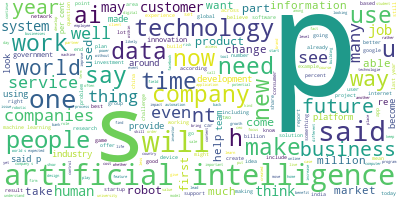

In [7]:
#Remove punctuation, from https://stackoverflow.com/a/50444347
import string

punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct, ''))

df['body'] = '|'.join(df['body'].tolist()).translate(transtab).split('|')

#Lowercase
df['body'] = df['body'].str.lower()

#Remove stopwords
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

#Wordcloud and LDA from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
from wordcloud import WordCloud

#Join bodies for wordcloud
all_bodies = ','.join(list(df['body'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(all_bodies)

# Visualize the word cloud
wordcloud.to_image()

In [13]:
data = df.body.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['country', 'aims', 'create', 'world', 'mostsecure', 'online', 'environment', 'build', 'defense', 'attack', 'capabilities', 'retaliate', 'targeted', 'foreign', 'states', 'chancellor', 'exchequer', 'philip', 'hammond', 'said', 'tuesday', 'hammond', 'announced', 'measures', 'part', 'uk', 'national', 'cyber', 'security', 'strategy']


In [12]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

wordcloud_input = ','.join(data_words)

# Generate a word cloud
wordcloud.generate(wordcloud_input)

# Visualize the word cloud
wordcloud.to_image()

TypeError: sequence item 0: expected str instance, list found

In [14]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 2), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2)]


In [15]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"new" + 0.005*"technology" + 0.005*"data" + 0.004*"said" + '
  '0.004*"also" + 0.004*"world" + 0.004*"ai" + 0.004*"intelligence" + '
  '0.004*"people" + 0.004*"business"'),
 (1,
  '0.007*"said" + 0.005*"new" + 0.005*"technology" + 0.005*"company" + '
  '0.005*"also" + 0.005*"people" + 0.004*"artificial" + 0.004*"world" + '
  '0.004*"intelligence" + 0.004*"like"'),
 (2,
  '0.008*"said" + 0.007*"new" + 0.005*"ai" + 0.005*"also" + 0.005*"technology" '
  '+ 0.004*"data" + 0.004*"company" + 0.004*"artificial" + '
  '0.004*"intelligence" + 0.003*"world"'),
 (3,
  '0.005*"data" + 0.004*"people" + 0.004*"new" + 0.004*"ai" + 0.004*"business" '
  '+ 0.004*"said" + 0.004*"companies" + 0.004*"company" + 0.004*"one" + '
  '0.004*"nt"'),
 (4,
  '0.006*"said" + 0.005*"ai" + 0.005*"new" + 0.004*"us" + 0.004*"one" + '
  '0.003*"people" + 0.003*"would" + 0.003*"also" + 0.003*"intelligence" + '
  '0.003*"technology"'),
 (5,
  '0.006*"ai" + 0.006*"said" + 0.005*"nt" + 0.005*"new" + 0.004*"on

In [16]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('C://NOW/results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'C://NOW/results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.008411 -0.002726       1        1  18.757364
5     -0.006988  0.008089       2        1  16.075813
6     -0.005415 -0.009032       3        1  11.532202
1     -0.000592  0.005494       4        1  10.986980
2      0.007634  0.002094       5        1  10.695779
8     -0.003610  0.001381       6        1  10.309659
0      0.005046  0.001811       7        1   8.272891
7      0.000598 -0.001409       8        1   6.168647
4     -0.002956 -0.002865       9        1   4.266835
3     -0.002127 -0.002838      10        1   2.933829, topic_info=            Term          Freq         Total Category  logprob  loglift
58          data  17152.000000  17152.000000  Default  30.0000  30.0000
157          new  23229.000000  23229.000000  Default  29.0000  29.0000
167       people  14156.000000  14156.000000  Default  28.0000  28.0000
285           ai  17505.000000  17505.000000  Default  27.0000  27.0000
199         said  24191.000000  24191.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
7           also    370.430865  17943.354650  Topic10  -5.8517  -0.3514
256         year    279.114007  11349.832576  Topic10  -6.1347  -0.1765
1394  technology    314.024155  21403.090155  Topic10  -6.0169  -0.6930
1545       years    245.776527  10090.495555  Topic10  -6.2619  -0.1861
1569     digital    240.028505   9648.492676  Topic10  -6.2856  -0.1649

[885 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1628       1  0.165445     access
1628       2  0.156437     access
1628       3  0.112599     access
1628       4  0.104792     access
1628       5  0.106293     access
...      ...       ...        ...
49086      4  0.145110  zestmoney
49086      5  0.435331  zestmoney
24942      3  0.660793     zoomer
24942      5  0.132159     zoomer
24942      8  0.132159     zoomer

[3174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 7, 2, 3, 9, 1, 8, 5, 4])

### Other sources:

Other popular sources for internet data:

[reddit](https://www.reddit.com/) - https://praw.readthedocs.io/en/v2.1.21/

[twitter](https://twitter.com/) - https://pypi.org/project/python-twitter/

[project gutenburg](https://www.gutenberg.org/) - https://github.com/ageitgey/Gutenberg 

